### Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import platform
import sys
import gc
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelBinarizer
import PIL
from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot

import keras
from keras.applications import InceptionV3
from keras import layers
from keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras import optimizers
from keras import models
from keras.models import Sequential, Model
from keras import preprocessing
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import plot_model
import tensorflow as tf

2023-08-26 15:36:16.451964: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-26 15:36:16.486567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 15:36:17.068938: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Enable Cuda if OS is Windows

In [2]:
if platform.system() == 'Windows':
    device = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Set path and get all classes. ".DS_Store" needs to be removed on MacOS againa

In [4]:
d = '/home/sebastian/Documents/Hauptprojekt/Daten_sorted/'
classes = (os.listdir(d))
print(os.device_encoding) 
if "._.DS_Store" in classes:
    classes.remove("._.DS_Store")
if ".DS_Store" in classes:
    classes.remove(".DS_Store")

<built-in function device_encoding>


In [5]:
print(classes)

['sales_order', 'purchase_order', 'utility_bill', 'debit_note', 'order', 'receipt', 'proforma', 'tax_invoice', 'credit_note']


### Global variables

In [6]:
img_size = 299
batch_size = 32
epochs = 100
train_size = 0.7
val_size = 0.2
test_size = 0.1
seed = 4321
channels = 3
learning_rate = 0.00001

### Get all data

In [7]:
total_set = []
total_labels = []
counter_tax = 0 
counter_order = 0


for root, dirs, files in os.walk(d):
    for file in files:
        if file.endswith(".jpg"):
            label = root.split(os.path.sep)[-1]
            if label == "tax_invoice":
                counter_tax +=1
                if counter_tax % 10 == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            elif label == "order":
                counter_order +=1
                if counter_order % 5 == 0:
                    path = os.path.join(root, file)
                    total_set.append(path)
                    total_labels.append(label)
            else:    
                path = os.path.join(root, file)
                total_set.append(path)
                total_labels.append(label)
            

# Return image class based on list entry (path)         
def getClass(img):
    return img.split(os.path.sep)[-2]


print(total_set[0])
print('GetClass : ', getClass(total_set[0]))
print('Label : ', total_labels[0])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/sales_order/synthetic-6a8be7d3aa8c44d6af9a2656-052(1).jpg
GetClass :  sales_order
Label :  sales_order


/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-60342157e5654d1292205df4-813(1).jpg


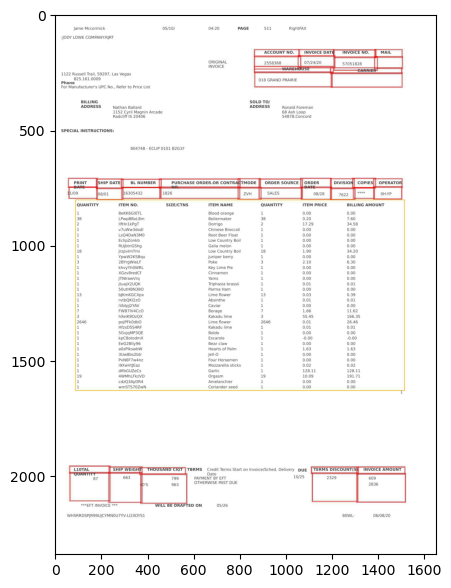

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/receipt/synthetic-410651d35003486c860e6985-120(1).jpg


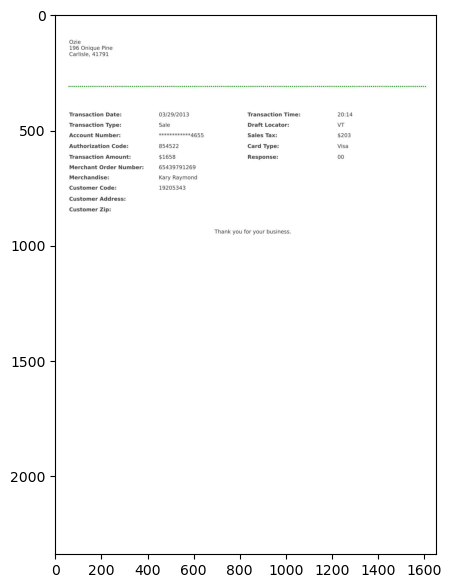

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-1c5cf2840ec745479b53bcad-958(1).jpg


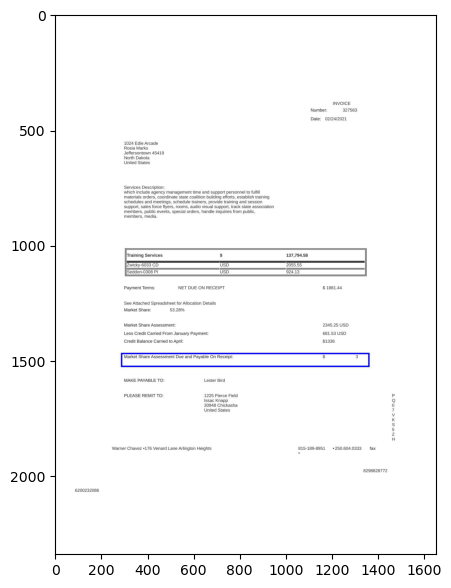

In [8]:
random.Random(seed).shuffle(total_set)

for ima in total_set[0:3] :
    print(ima)
    img = mpimg.imread(ima)
    plt.figure(figsize=(7,7))
    imgplot = plt.imshow(img, cmap="gray")
    plt.show()

### Sorting data in usable sets¶

In [9]:
# Get data and separate it in sets
total_len = len(total_set)
index = 0

train_set = []
train_label = []

val_set = []
val_label = []

test_set = []
test_label = []


for i in total_set[0: int(total_len*train_size)] :
    train_set.append(i)
    train_label.append(getClass(i))
    
index = int(total_len*train_size)+1
    
for i in total_set[index: int(index + total_len*val_size)] :
    val_set.append(i)
    val_label.append(getClass(i))
    
index = int(index + total_len*val_size)+1 

for i in total_set[index: total_len] :
    test_set.append(i)
    test_label.append(getClass(i))

print(val_set[200])
print(val_label[200])

/home/sebastian/Documents/Hauptprojekt/Daten_sorted/tax_invoice/synthetic-8a30b38f74cf4752bb0d6d06-172(1).jpg
tax_invoice


### Visualize class distribution

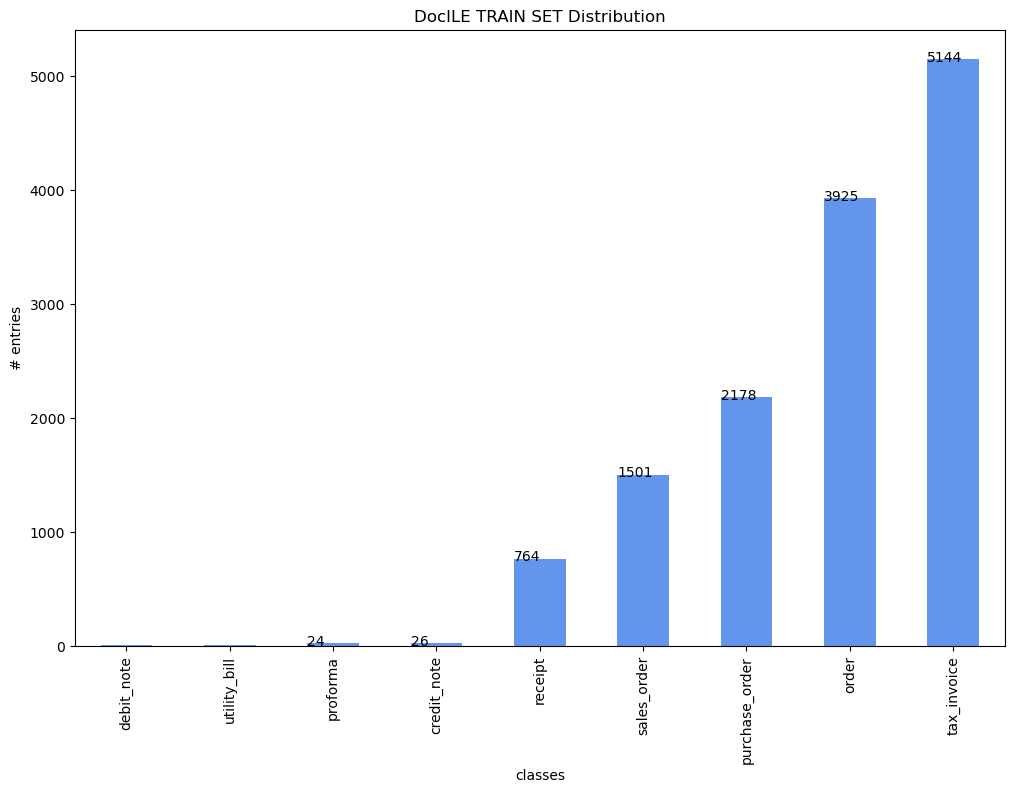

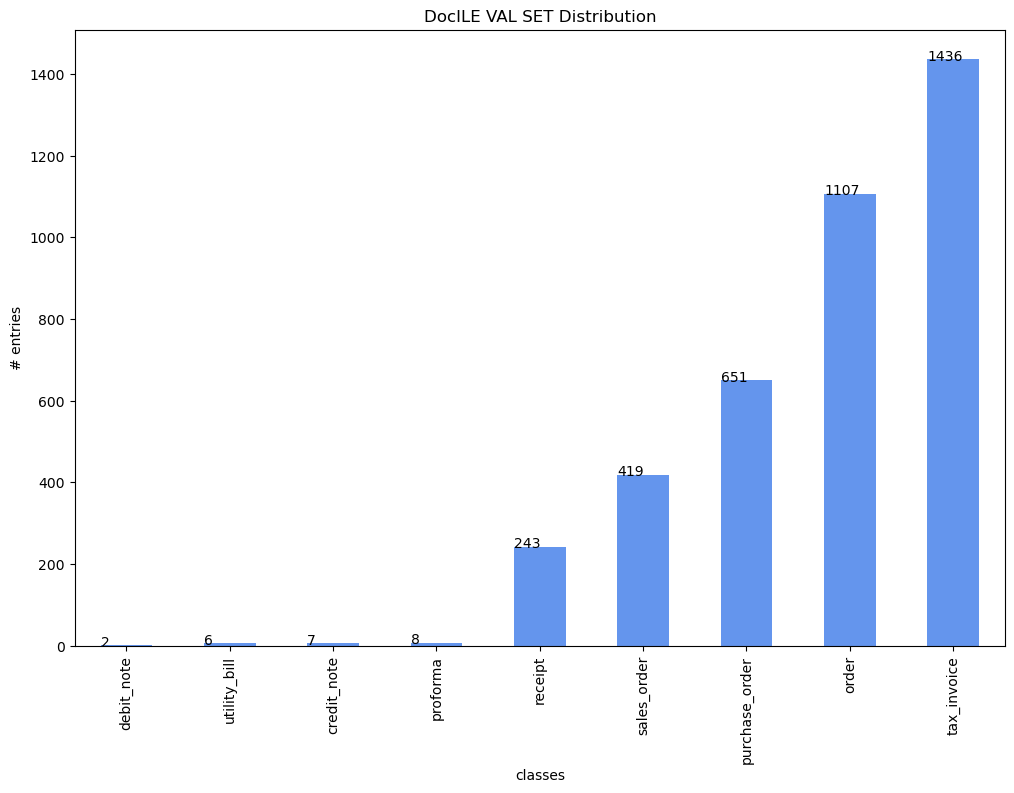

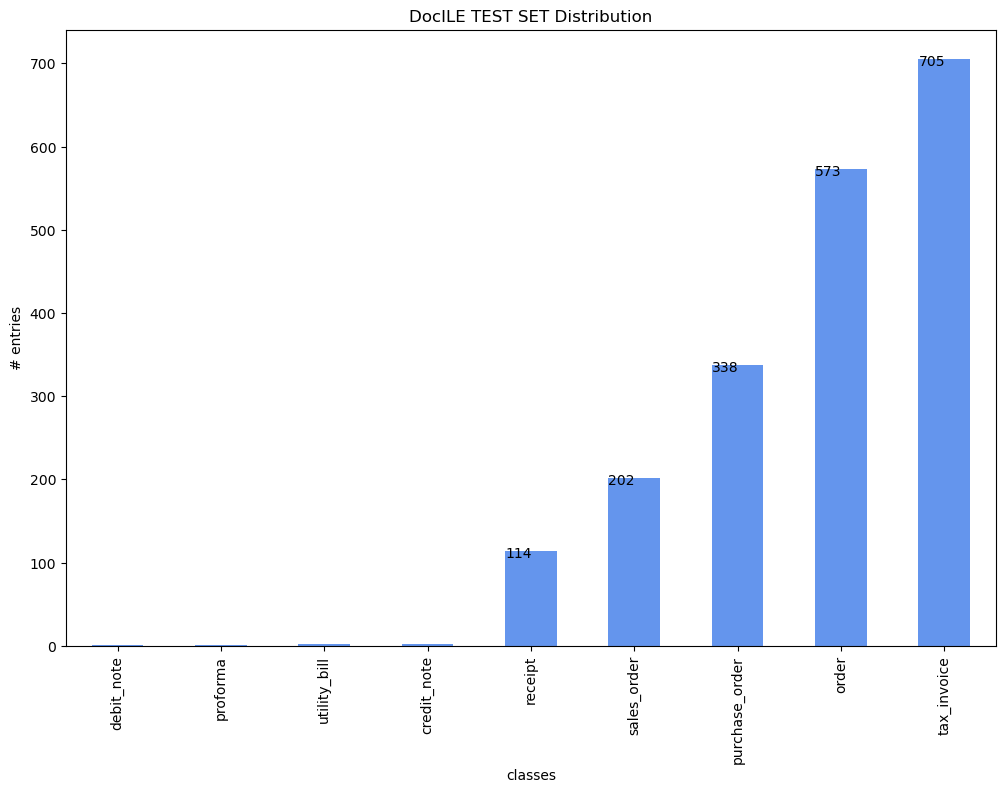

In [10]:
#################################################
# TRAIN SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in train_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TRAIN SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-20))

#################################################
# VAL SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in val_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE VAL SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-3))
    
#################################################
# TEST SET
instances = [0] * len(classes)
for index, val in enumerate(classes) :
    for e in test_set :
        if(val == getClass(e)) :
            instances[index] += 1

            
df = pd.DataFrame({'classes':classes, 'entries':instances})
ax = df.sort_values(by='entries', ascending=True).plot.bar(x='classes', y='entries', color='cornflowerblue',legend=False, figsize=(12,8))
ax.set_title('DocILE TEST SET Distribution')
ax.set_ylabel("# entries")
for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x(), p.get_height()-8))

### Preprocess data (resize and transform to Numpy array)

In [11]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
    
    return processed_img
    
x_train = process_images(train_set)

KeyboardInterrupt: 

In [19]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
   
    return processed_img
    
x_test = process_images(test_set)

In [20]:
def process_images(img_set) : 
    processed_img = []

    for i in range(len(img_set)):
        processed_img.append(cv2.resize(cv2.imread(img_set[i], cv2.IMREAD_COLOR), (img_size, img_size)))
    
    return processed_img
    
x_val = process_images(val_set)

train shape :  (13576, 299, 299, 3)
(13576, 9)
test shape :  (1938, 299, 299, 3)
(1938, 9)
valdiation shape :  (3879, 299, 299, 3)
(3879, 9)
tax_invoice
[0 0 0 0 0 0 0 1 0]
['credit_note' 'debit_note' 'order' 'proforma' 'purchase_order' 'receipt'
 'sales_order' 'tax_invoice' 'utility_bill']


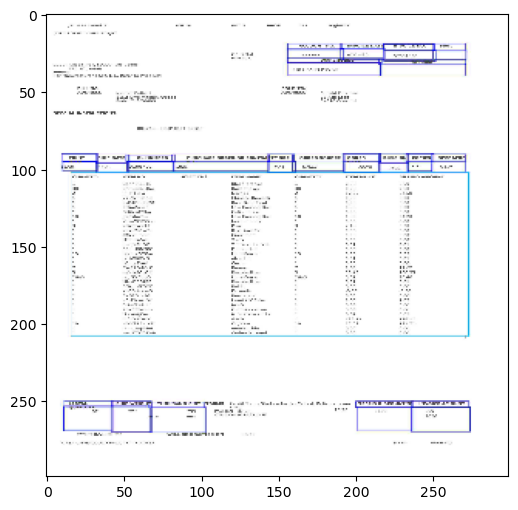

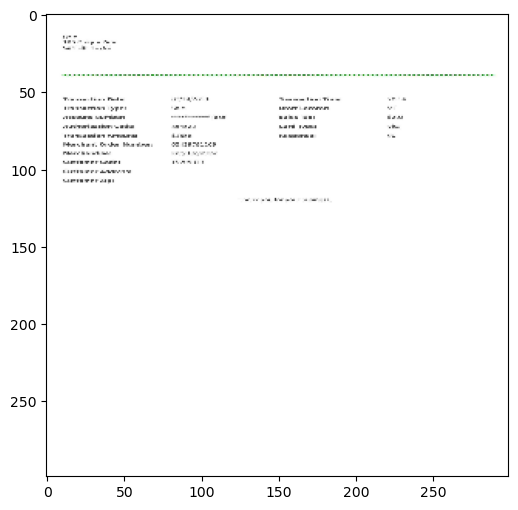

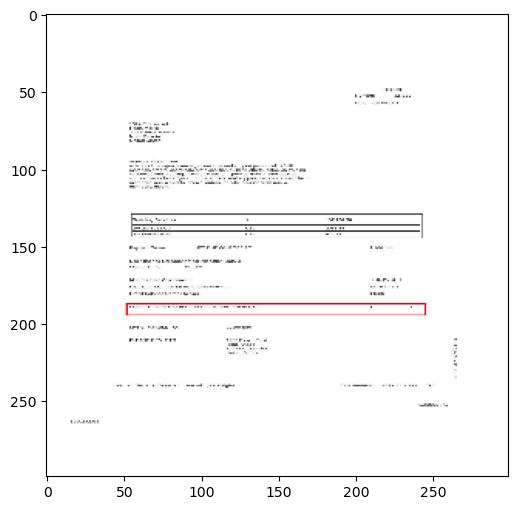

In [25]:
lb = LabelBinarizer()
lb.fit(list(classes))

x_train = np.array(x_train)
y_train =lb.transform(np.array(train_label))

x_test = np.array(x_test)
y_test = lb.transform(np.array(test_label))

x_val = np.array(x_val)
y_val = lb.transform(np.array(val_label))

print("train shape : ", x_train.shape)
print(y_train.shape)
print("test shape : ", x_test.shape)
print(y_test.shape)
print("valdiation shape : ", x_val.shape)
print(y_val.shape)


for i in range(3) :
    plt.figure(figsize=(6,6))
    imgplot = plt.imshow(x_train[i])

print(train_label[0])
print(y_train[0])
print(lb.classes_)

### Save the sets to .npy file for use after restarting runtime

In [22]:
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_train.npy', x_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_test.npy', x_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_train.npy', y_train)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_test.npy', y_test)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_val.npy', x_val)
np.save('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_val.npy', y_val)

### load sets after restarting runtime

In [11]:
x_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_train.npy')
x_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_test.npy')
y_train = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_train.npy')
y_test = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_test.npy')
x_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/x_val.npy')
y_val = np.load('/home/sebastian/Documents/Hauptprojekt/Arrays/InceptionV3/y_val.npy')

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


Creating model (pretrained CNN) InceptionV3

In [13]:
base_model = InceptionV3(weights = "imagenet", include_top=False, input_shape = (img_size, img_size, channels))

for layer in base_model.layers:
    layer.trainable = False
    
base_model.summary()

2023-08-26 15:36:42.758196: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22015 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

 conv2d_11 (Conv2D)          (None, 35, 35, 32)           6144      ['average_pooling2d[0][0]']   
                                                                                                  
 batch_normalization_5 (Bat  (None, 35, 35, 64)           192       ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_7 (Bat  (None, 35, 35, 64)           192       ['conv2d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 batch_normalization_10 (Ba  (None, 35, 35, 96)           288       ['conv2d_10[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_17 (Activation)  (None, 35, 35, 96)           0         ['batch_normalization_17[0][0]
                                                                    ']                            
                                                                                                  
 activation_18 (Activation)  (None, 35, 35, 64)           0         ['batch_normalization_18[0][0]
                                                                    ']                            
                                                                                                  
 mixed1 (Concatenate)        (None, 35, 35, 288)          0         ['activation_12[0][0]',       
                                                                     'activation_14[0][0]',       
                                                                     'activation_17[0][0]',       
          

                                                                                                  
 conv2d_28 (Conv2D)          (None, 35, 35, 96)           55296     ['activation_27[0][0]']       
                                                                                                  
 batch_normalization_28 (Ba  (None, 35, 35, 96)           288       ['conv2d_28[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_28 (Activation)  (None, 35, 35, 96)           0         ['batch_normalization_28[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_26 (Conv2D)          (None, 17, 17, 384)          995328    ['mixed2[0][0]']              
          

 conv2d_30 (Conv2D)          (None, 17, 17, 192)          147456    ['mixed3[0][0]']              
                                                                                                  
 conv2d_33 (Conv2D)          (None, 17, 17, 192)          172032    ['activation_32[0][0]']       
                                                                                                  
 conv2d_38 (Conv2D)          (None, 17, 17, 192)          172032    ['activation_37[0][0]']       
                                                                                                  
 conv2d_39 (Conv2D)          (None, 17, 17, 192)          147456    ['average_pooling2d_3[0][0]'] 
                                                                                                  
 batch_normalization_30 (Ba  (None, 17, 17, 192)          576       ['conv2d_30[0][0]']           
 tchNormalization)                                                                                
          

                                                                    ']                            
                                                                                                  
 average_pooling2d_4 (Avera  (None, 17, 17, 768)          0         ['mixed4[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_40 (Conv2D)          (None, 17, 17, 192)          147456    ['mixed4[0][0]']              
                                                                                                  
 conv2d_43 (Conv2D)          (None, 17, 17, 192)          215040    ['activation_42[0][0]']       
                                                                                                  
 conv2d_48 (Conv2D)          (None, 17, 17, 192)          215040    ['activation_47[0][0]']       
          

                                                                                                  
 activation_52 (Activation)  (None, 17, 17, 160)          0         ['batch_normalization_52[0][0]
                                                                    ']                            
                                                                                                  
 activation_57 (Activation)  (None, 17, 17, 160)          0         ['batch_normalization_57[0][0]
                                                                    ']                            
                                                                                                  
 average_pooling2d_5 (Avera  (None, 17, 17, 768)          0         ['mixed5[0][0]']              
 gePooling2D)                                                                                     
                                                                                                  
 conv2d_50

 batch_normalization_62 (Ba  (None, 17, 17, 192)          576       ['conv2d_62[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_67 (Ba  (None, 17, 17, 192)          576       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_62 (Activation)  (None, 17, 17, 192)          0         ['batch_normalization_62[0][0]
                                                                    ']                            
                                                                                                  
 activation_67 (Activation)  (None, 17, 17, 192)          0         ['batch_normalization_67[0][0]
          

                                                                                                  
 conv2d_71 (Conv2D)          (None, 8, 8, 320)            552960    ['activation_70[0][0]']       
                                                                                                  
 conv2d_75 (Conv2D)          (None, 8, 8, 192)            331776    ['activation_74[0][0]']       
                                                                                                  
 batch_normalization_71 (Ba  (None, 8, 8, 320)            960       ['conv2d_71[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 batch_normalization_75 (Ba  (None, 8, 8, 192)            576       ['conv2d_75[0][0]']           
 tchNormalization)                                                                                
          

                                                                                                  
 activation_82 (Activation)  (None, 8, 8, 384)            0         ['batch_normalization_82[0][0]
                                                                    ']                            
                                                                                                  
 activation_83 (Activation)  (None, 8, 8, 384)            0         ['batch_normalization_83[0][0]
                                                                    ']                            
                                                                                                  
 batch_normalization_84 (Ba  (None, 8, 8, 192)            576       ['conv2d_84[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activatio

                                                                                                  
 activation_88 (Activation)  (None, 8, 8, 384)            0         ['batch_normalization_88[0][0]
                                                                    ']                            
                                                                                                  
 activation_91 (Activation)  (None, 8, 8, 384)            0         ['batch_normalization_91[0][0]
                                                                    ']                            
                                                                                                  
 activation_92 (Activation)  (None, 8, 8, 384)            0         ['batch_normalization_92[0][0]
                                                                    ']                            
                                                                                                  
 batch_nor

### finetune model

In [14]:
model = models.Sequential()

model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu',  name='dense'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(classes), activation='softmax',  name='predictions'))

'''x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x) 
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)'''

model.summary()

print('Number of trainable weights : ', len(model.trainable_weights))

plot_model(model, to_file='model_InceptionV3.png')
#SVG(model_to_dot(model).create(prog='dot', format='svg'))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 9)                 1161      
                                                                 
Total params: 38581289 (147.18 MB)
Trainable params: 16778505 (64.00 MB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________
Number 

In [15]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [16]:
model.compile(optimizer=optimizers.legacy.Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy', f1_m,precision_m, recall_m])

train_model = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_val, y_val))

Epoch 1/100


2023-08-26 15:37:01.038155: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-26 15:37:01.096983: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-08-26 15:37:01.099956: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-08-26 15:37:01.099992: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-08-26 15:37:01.100106: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-08-26 

425/425 [==============================] - 25s 50ms/step - loss: 3.0207 - accuracy: 0.4881 - f1_m: 0.4538 - precision_m: 0.6596 - recall_m: 0.3547 - val_loss: 0.6694 - val_accuracy: 0.7837 - val_f1_m: 0.7438 - val_precision_m: 0.8870 - val_recall_m: 0.6439
Epoch 2/100
425/425 [==============================] - 18s 43ms/step - loss: 1.0926 - accuracy: 0.5838 - f1_m: 0.5705 - precision_m: 0.7711 - recall_m: 0.4582 - val_loss: 0.4829 - val_accuracy: 0.8505 - val_f1_m: 0.8284 - val_precision_m: 0.9075 - val_recall_m: 0.7653
Epoch 3/100
425/425 [==============================] - 18s 43ms/step - loss: 0.9723 - accuracy: 0.6243 - f1_m: 0.6257 - precision_m: 0.8162 - recall_m: 0.5125 - val_loss: 0.4435 - val_accuracy: 0.8618 - val_f1_m: 0.8463 - val_precision_m: 0.9172 - val_recall_m: 0.7886
Epoch 4/100
425/425 [==============================] - 18s 43ms/step - loss: 0.9161 - accuracy: 0.6409 - f1_m: 0.6503 - precision_m: 0.8286 - recall_m: 0.5398 - val_loss: 0.4372 - val_accuracy: 0.8763 - va

425/425 [==============================] - 19s 44ms/step - loss: 0.6070 - accuracy: 0.7211 - f1_m: 0.7299 - precision_m: 0.8274 - recall_m: 0.6554 - val_loss: 0.1997 - val_accuracy: 0.9716 - val_f1_m: 0.9736 - val_precision_m: 0.9808 - val_recall_m: 0.9667
Epoch 62/100
425/425 [==============================] - 19s 44ms/step - loss: 0.5953 - accuracy: 0.7181 - f1_m: 0.7295 - precision_m: 0.8258 - recall_m: 0.6558 - val_loss: 0.2004 - val_accuracy: 0.9704 - val_f1_m: 0.9726 - val_precision_m: 0.9790 - val_recall_m: 0.9664
Epoch 63/100
425/425 [==============================] - 19s 44ms/step - loss: 0.5932 - accuracy: 0.7245 - f1_m: 0.7324 - precision_m: 0.8262 - recall_m: 0.6600 - val_loss: 0.2291 - val_accuracy: 0.9624 - val_f1_m: 0.9659 - val_precision_m: 0.9754 - val_recall_m: 0.9570
Epoch 64/100
425/425 [==============================] - 19s 44ms/step - loss: 0.5987 - accuracy: 0.7228 - f1_m: 0.7302 - precision_m: 0.8269 - recall_m: 0.6565 - val_loss: 0.1889 - val_accuracy: 0.9740 -

In [17]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_test, y_test, verbose=0)

save Model

In [18]:
model.save('/home/sebastian/Documents/Hauptprojekt/Models/InceptionV3/trained_model_added_layer_100epochs_10_5.h5')

/home/sebastian/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.load('')

### Plot training accuracy and loss

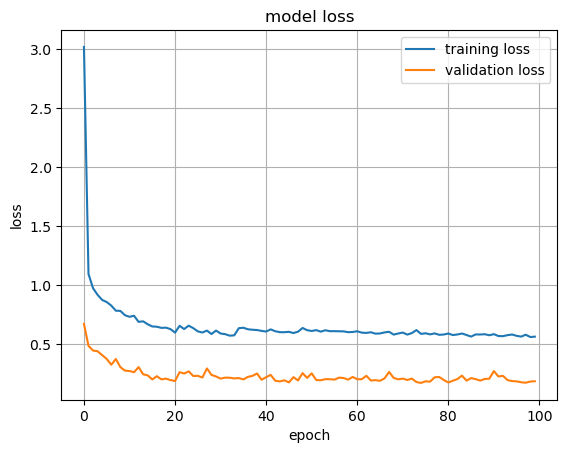

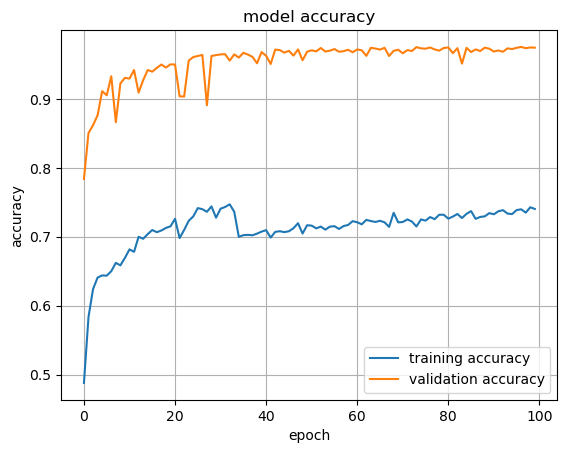

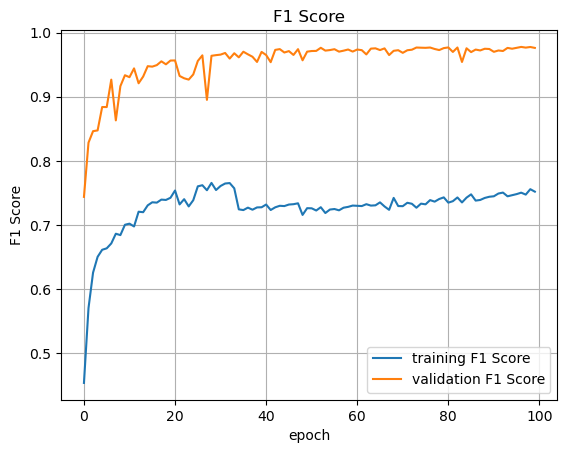

In [19]:
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.legend(['training loss', 'validation loss'], loc='upper right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/InceptionV3/model_loss_added_layer_100epochs_10_5.png')
plt.show()


plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training accuracy', 'validation accuracy'], loc='lower right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/InceptionV3/model_acc_added_layer_100epochs_10_5.png')
plt.show()


plt.plot(train_model.history['f1_m'])
plt.plot(train_model.history['val_f1_m'])
plt.title('F1 Score')
plt.grid()
plt.ylabel('F1 Score')
plt.xlabel('epoch')
plt.legend(['training F1 Score', 'validation F1 Score'], loc='lower right')
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/InceptionV3/F1_added_layer_100epochs_10_5.png')
plt.show()


### Plot prediction accuracy

In [20]:
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


61/61 [==============================] - 2s 34ms/step - loss: 0.1823 - accuracy: 0.9752 - f1_m: 0.9770 - precision_m: 0.9814 - recall_m: 0.9728
Test loss: 0.1822713017463684
Test accuracy: 0.9752321839332581


Use Model on test set

In [21]:
lb = LabelBinarizer()
lb.fit(list(classes))

false_pred = []
true_pred = []

predictions=model.predict(x_test) 
predictions_list = predictions.tolist()
predicted_classes=np.argmax(predictions,axis=1)



count_true = 0
count_false = 0

for i, prediction in enumerate(predictions_list):
    state = True
    if (lb.classes_[predicted_classes[i]] != test_label[i]) :
        state = False
        count_false += 1
        false_pred.append(test_label[i])
    else :
        true_pred.append(test_label[i])
        count_true += 1
    print("Prediction : ", classes[predicted_classes[i]], "   |   Real class : ", test_label[i],  "   |   Result : ", state)

print("\nNumber of success : ", count_true) 
print("Number of error : ", count_false) 
print("Error rate : ", count_true/len(test_label))

61/61 [==============================] - 2s 28ms/step
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
Prediction :  receipt    |   Real class :  receipt    |   Result :  True
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
Prediction :  utility_bill    |   Real class :  order    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :  tax_invoice    |   Real class :  tax_invoice    |   Result :  True
Prediction :

Print wrong classifications per class

In [22]:
print(f'"debit_note" was classified wrong {false_pred.count("debit_note")} time(s) out of {false_pred.count("debit_note") + true_pred.count("debit_note")} time(s)')
print(f'"proforma" was classified wrong {false_pred.count("proforma")} time(s) out of {false_pred.count("proforma") + true_pred.count("proforma")} time(s)')
print(f'"utility_bill" was classified wrong {false_pred.count("utility_bill")} time(s) out of {false_pred.count("utility_bill") + true_pred.count("utility_bill")} time(s)')
print(f'"credit_note" was classified wrong {false_pred.count("credit_note")} time(s) out of {false_pred.count("credit_note") + true_pred.count("credit_note")} time(s)')
print(f'"receipt" was classified wrong {false_pred.count("receipt")} time(s) out of {false_pred.count("receipt") + false_pred.count("receipt")} time(s)')
print(f'"sales_order" was classified wrong {false_pred.count("sales_order")} time(s) out of {false_pred.count("sales_order") + true_pred.count("sales_order")} time(s)')
print(f'"purchase_order" was classified wrong {false_pred.count("purchase_order")} time(s) out of {false_pred.count("purchase_order") + true_pred.count("purchase_order")} time(s)')
print(f'"order" was classified wrong {false_pred.count("order")} time(s) out of {false_pred.count("order") + true_pred.count("order")} time(s)')
print(f'"tax_invoice" was classified wrong {false_pred.count("tax_invoice")} time(s) out of {false_pred.count("tax_invoice") + true_pred.count("tax_invoice")} time(s)')

"debit_note" was classified wrong 1 time(s) out of 1 time(s)
"proforma" was classified wrong 1 time(s) out of 1 time(s)
"utility_bill" was classified wrong 2 time(s) out of 2 time(s)
"credit_note" was classified wrong 2 time(s) out of 2 time(s)
"receipt" was classified wrong 12 time(s) out of 24 time(s)
"sales_order" was classified wrong 1 time(s) out of 202 time(s)
"purchase_order" was classified wrong 2 time(s) out of 338 time(s)
"order" was classified wrong 17 time(s) out of 573 time(s)
"tax_invoice" was classified wrong 10 time(s) out of 705 time(s)


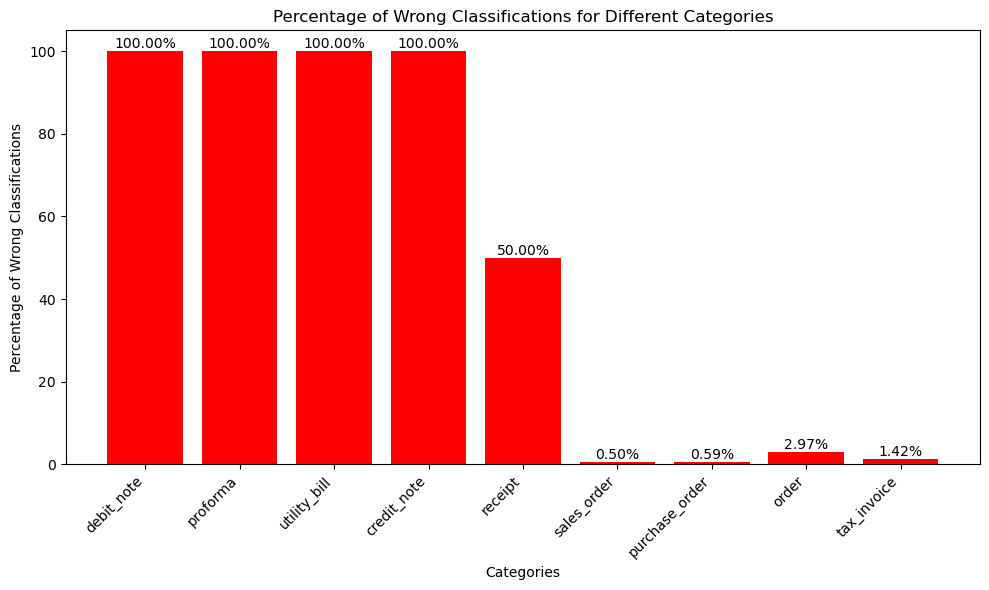

In [25]:
import matplotlib.pyplot as plt

# Data
categories = [
    "debit_note",
    "proforma",
    "utility_bill",
    "credit_note",
    "receipt",
    "sales_order",
    "purchase_order",
    "order",
    "tax_invoice"
]

wrong_counts = [
    false_pred.count("debit_note"),  # debit_note
    false_pred.count("proforma"),  # proforma
    false_pred.count("utility_bill"),  # utility_bill
    false_pred.count("credit_note"),  # credit_note
    false_pred.count("receipt"), # receipt
    false_pred.count("sales_order"),  # sales_order
    false_pred.count("purchase_order"),  # purchase_order
    false_pred.count("order"), # order
    false_pred.count("tax_invoice")  # tax_invoice
]

total_counts = [
    false_pred.count("debit_note") + true_pred.count("debit_note"),   # debit_note
    false_pred.count("proforma") + true_pred.count("proforma"),   # proforma
    false_pred.count("utility_bill") + true_pred.count("utility_bill"),   # utility_bill
    false_pred.count("credit_note") + true_pred.count("credit_note"),   # credit_note
    false_pred.count("receipt") + true_pred.count("receipt"),  # receipt
    false_pred.count("sales_order") + true_pred.count("sales_order"), # sales_order
    false_pred.count("purchase_order") + true_pred.count("purchase_order"), # purchase_order
    false_pred.count("order") + true_pred.count("order"), # order
    false_pred.count("tax_invoice") + true_pred.count("tax_invoice")  # tax_invoice
]

# Calculate percentage of wrong classifications
wrong_percentages = [wrong / total * 100 for wrong, total in zip(wrong_counts, total_counts)]

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, wrong_percentages, color='red')
plt.xlabel('Categories')
plt.ylabel('Percentage of Wrong Classifications')
plt.title('Percentage of Wrong Classifications for Different Categories')
plt.xticks(rotation=45, ha='right')

# Add numbers to the bars
for bar, wrong_percentage in zip(bars, wrong_percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f'{wrong_percentage:.2f}%',
        ha='center',
        va='bottom',
        color='black',
        fontsize=10
    )

plt.tight_layout()
plt.savefig('/home/sebastian/Documents/Hauptprojekt/Plots/InceptionV3/Classification_added_layer_100epochs_10_5.png')
plt.show()